## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

        
cv2.destroyAllWindows()

## Display the Camera Calibration Results

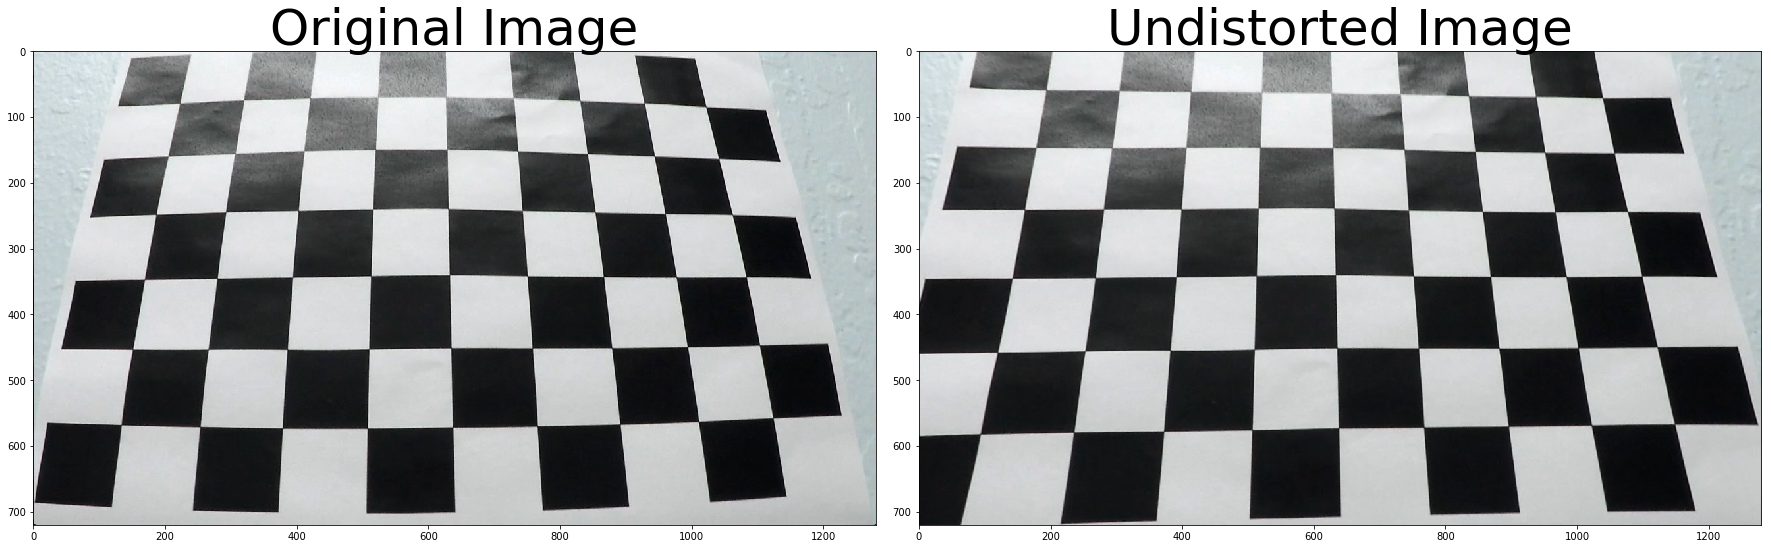

In [2]:
# performs the camera calibration, image distortion correction and returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #undist = np.copy(img)  # Delete this line
    return undist


img = cv2.imread(images[13])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
undistorted = cal_undistort(img, objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Pipeline (Test Images)
### Load Test Image

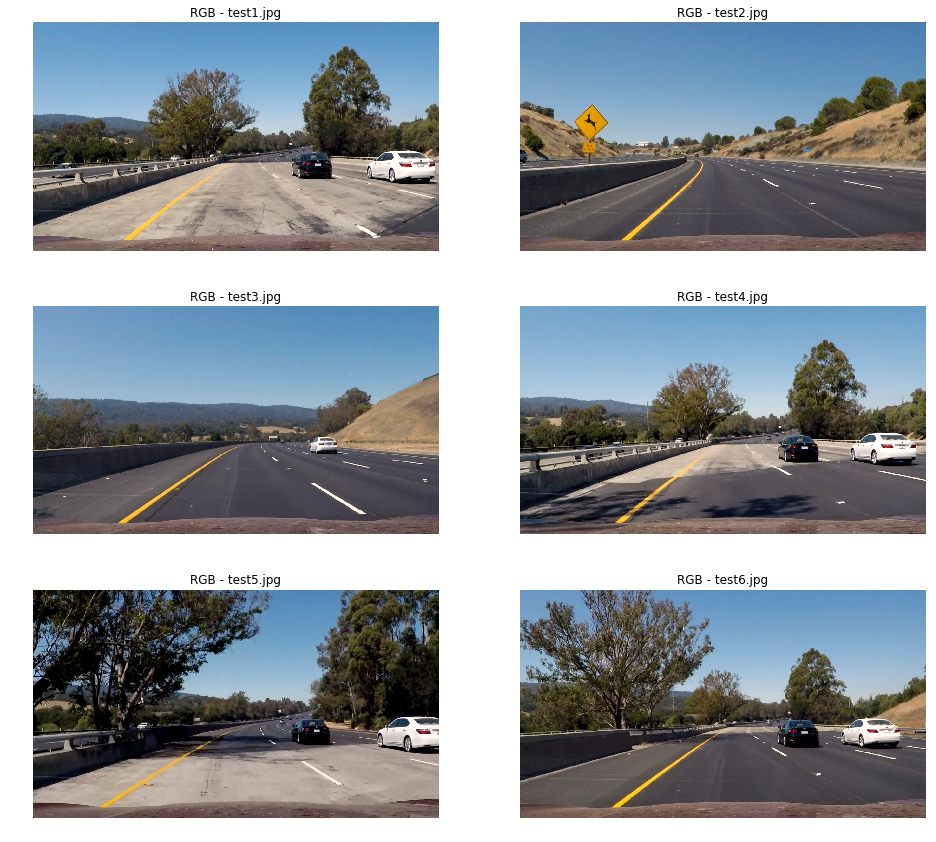

In [3]:
# Make a list of test images
images = glob.glob('./test_images/*.jpg')

def importRGB(imgPath):
    img = cv2.imread(imgPath)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return rgb

plt.figure(figsize=(16,20))
for n in range(2,len(images)):
    img = importRGB(images[n])
    plt.subplot(4,2,n+1)
    plt.axis('off')
    plt.title('RGB - '+images[n].split('\\')[-1])
    imgplot = plt.imshow(img)



### Distortion Correction

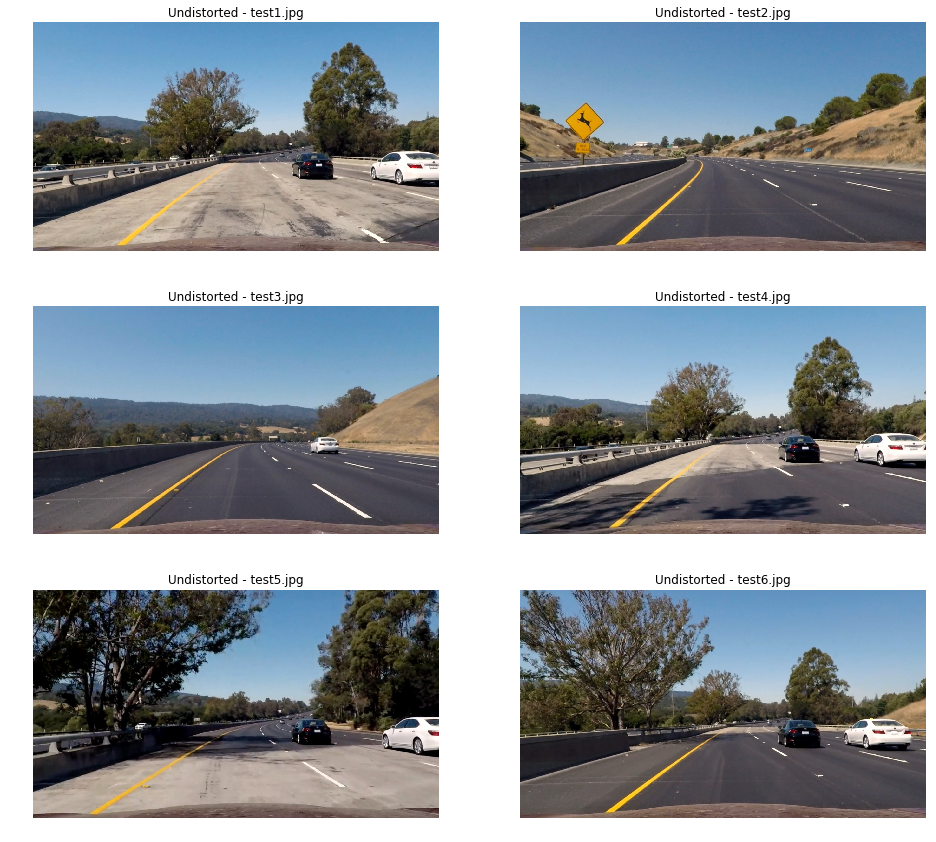

In [4]:
plt.figure(figsize=(16,20))
for n in range(2,len(images)):
    img = importRGB(images[n])
    undistorted = cal_undistort(img, objpoints, imgpoints)

    plt.subplot(4,2,n+1)
    plt.axis('off')
    plt.title('Undistorted - '+images[n].split('\\')[-1])
    imgplot = plt.imshow(undistorted)

### Colour and Gradient

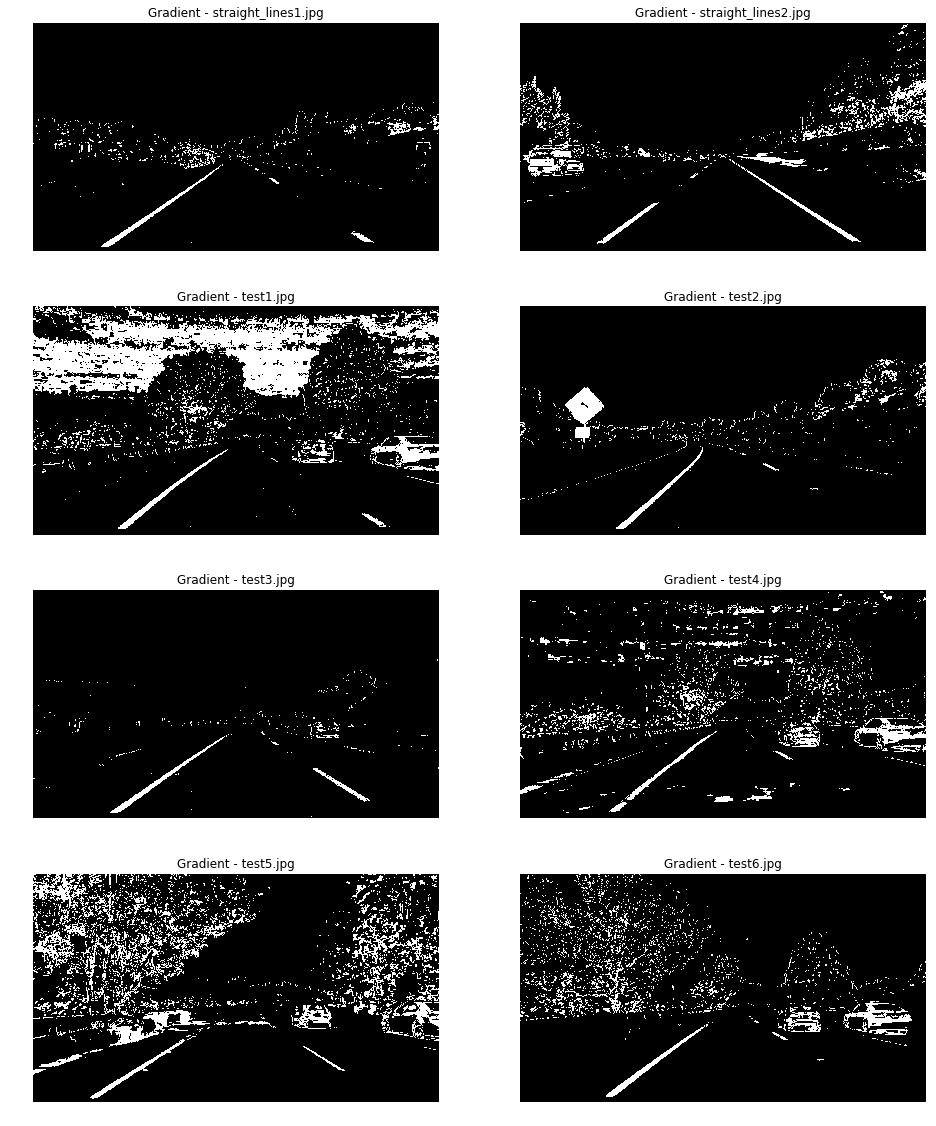

In [5]:
def colgrad(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
#     color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary > 0))
    color_binary = (sxbinary > 0) | (s_binary > 0)
    # map output to 0-255 as np.uint8 type
    color_binary = color_binary.astype(np.uint8)
    return color_binary
    
plt.figure(figsize=(16,20))
# img = importRGB(images[0])
# img = cal_undistort(img, objpoints, imgpoints)
# img = colgrad(img)

for n in range(len(images)):
    img = importRGB(images[n])
    img = cal_undistort(img, objpoints, imgpoints)
    img = colgrad(img, (125, 255), (50, 150))
    plt.subplot(4,2,n+1)
    plt.axis('off')
    plt.title('Gradient - '+images[n].split('\\')[-1])
    imgplot = plt.imshow(img,cmap='gray')

### Perspective Transform

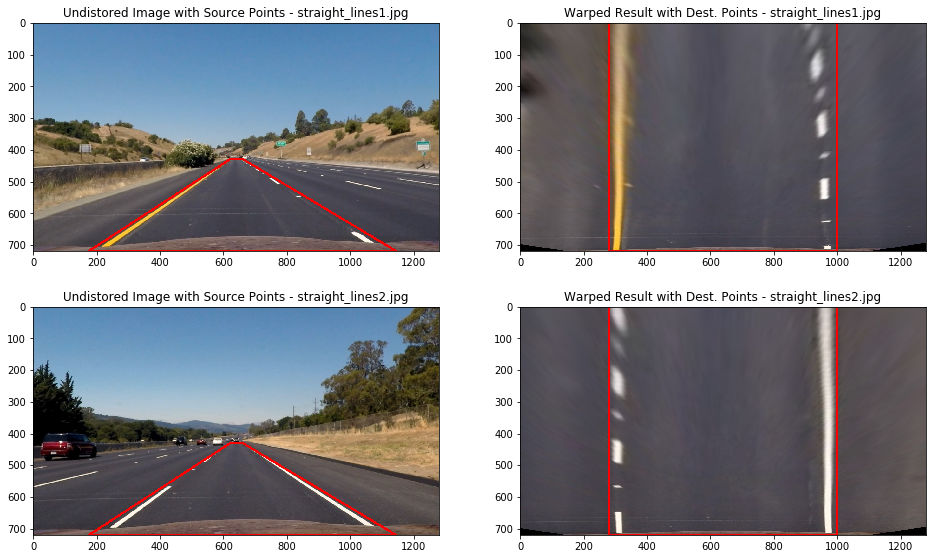

In [6]:
def perspectiveCorrect(img, src, dst):
    M = cv2.getPerspectiveTransform(src,dst)
    img = cv2.warpPerspective(img,M,(1280,720))
    return img

#                  left top right top       bottom  bottom
src = np.float32([[622,430],[660,430],[1145,720],[175,720]])
dst = np.float32([[280,-1000],[1000,-1000],[1000,720],[280,720]])

plt.figure(figsize=(16,20))
for n in range(0,2):
    img_rgb = importRGB(images[n])
    img_undistort = cal_undistort(img_rgb, objpoints, imgpoints)
    img_perspective = perspectiveCorrect(img_undistort, src, dst)
    
    plt.subplot(4,2,2*n+1)
    plt.title('Undistored Image with Source Points - '+images[n].split('\\')[-1])
    # overlay source points
    img_src = cv2.polylines(img_undistort,[src.astype(np.int32).reshape((-1,1,2))],True,(255,0,0),5);
    plt.imshow(img_src)

    plt.subplot(4,2,2*n+2)
    plt.title('Warped Result with Dest. Points - '+images[n].split('\\')[-1])
    # overlay destination points
    img_dst = cv2.polylines(img_perspective,[dst.astype(np.int32).reshape((-1,1,2))],True,(255,0,0),5)
    plt.imshow(img_dst)
    

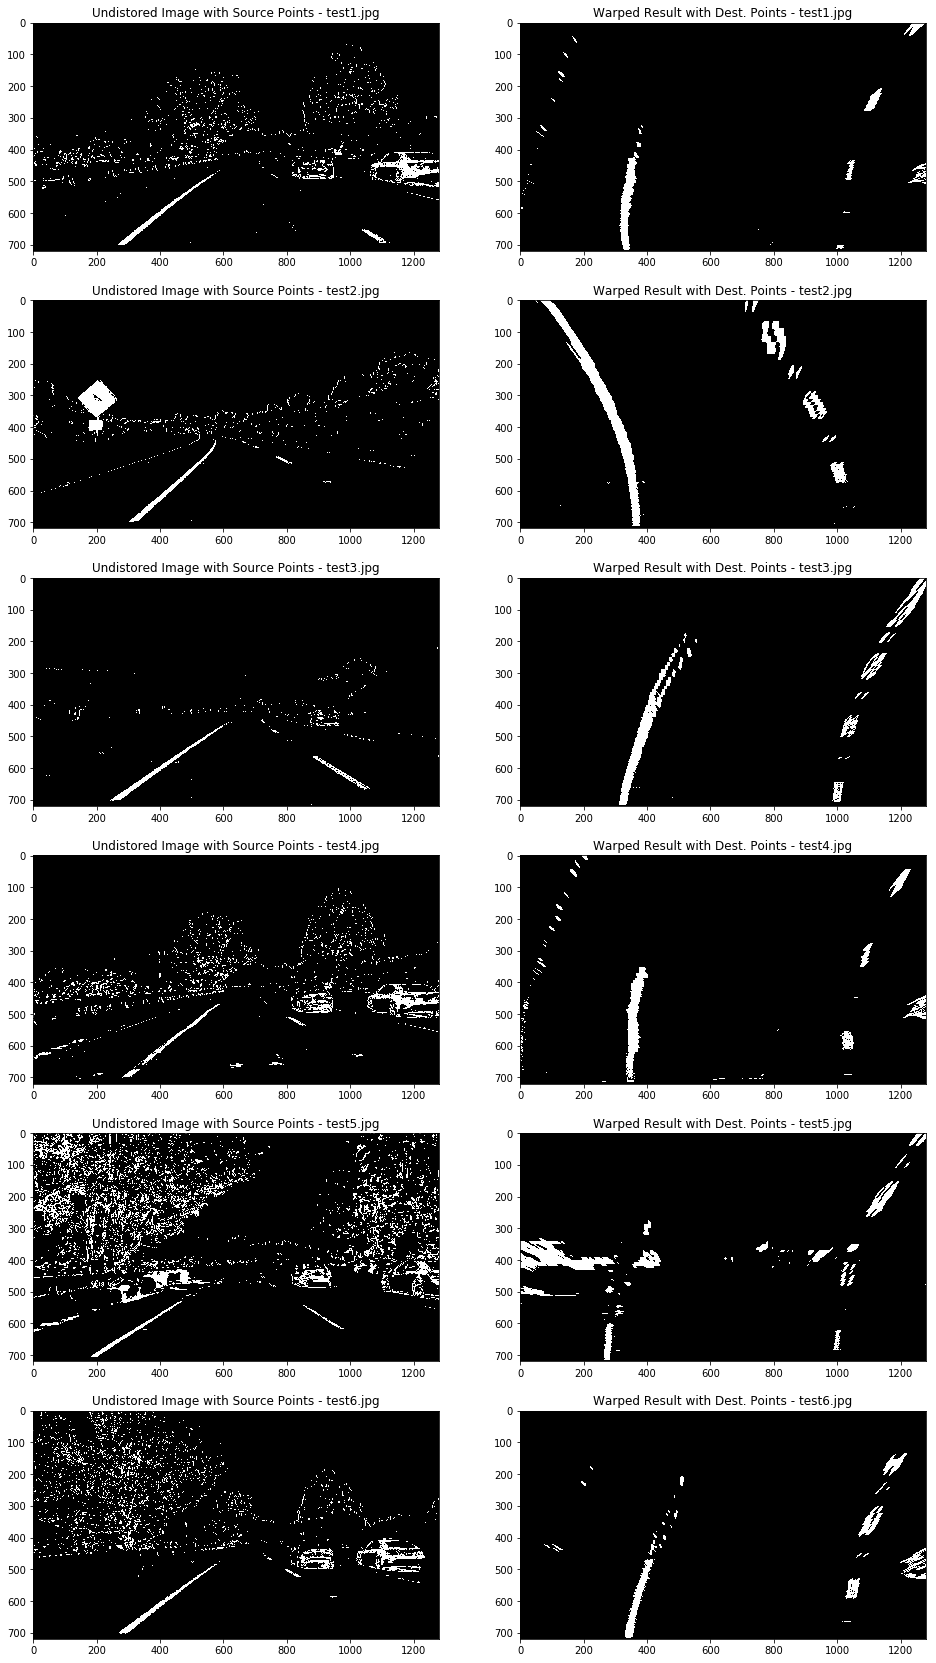

In [7]:
plt.figure(figsize=(16,40))
for n in range(2,len(images)):
    img_rgb = importRGB(images[n])
    img_undistort = cal_undistort(img_rgb, objpoints, imgpoints)
    img_colgrad = colgrad(img_undistort, (160, 255), (50, 150))
    img_perspective = perspectiveCorrect(img_colgrad, src, dst)
    
    plt.subplot(8,2,2*n+1)
    plt.title('Undistored Image with Source Points - '+images[n].split('\\')[-1])
    plt.imshow(img_colgrad,cmap='gray')

    plt.subplot(8,2,2*n+2)
    plt.title('Warped Result with Dest. Points - '+images[n].split('\\')[-1])
    plt.imshow(img_perspective,cmap='gray')

### Locate the Lane Lines and Fit a Polynomial

In [8]:
def slidingWindows(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 125
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # fitData[0] = left_fit, fitData[1] = right_fit, fitData[2] = out_img
    # fitData[3] = ploty, fitData[4] = left_fitx, fitData[5] = right_fitx
    fitData = [left_fit,right_fit,out_img,ploty,left_fitx,right_fitx]
    return fitData

In [9]:
def lineFit(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # assemble fitData for function output,
    # fitData[0] = left_fit, fitData[1] = right_fit, fitData[2] = out_img
    # fitData[3] = ploty, fitData[4] = left_fitx, fitData[5] = right_fitx
    fitData = [left_fit,right_fit,result,ploty,left_fitx,right_fitx]
    return fitData

In [13]:
def findRadius(left_fitx, right_fitx, ploty, ym_per_pix = 30/720, xm_per_pix = 3.7/700):

    y = np.max(ploty);

    

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    radii = [left_curverad,right_curverad]
    return radii


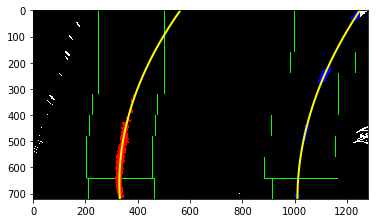

[  5.34984743e-04  -7.05612679e-01   5.62567271e+02] [  4.57044717e-04  -6.60081695e-01   1.24895219e+03]
[307.00466261786926, 359.32317544279471]


In [22]:
img_rgb = importRGB(images[2])
img_undistort = cal_undistort(img_rgb, objpoints, imgpoints)
img_colgrad = colgrad(img_undistort, (160, 255), (50, 150))
img_perspective = perspectiveCorrect(img_colgrad, src, dst)
fitData = slidingWindows(img_perspective)

plt.imshow(fitData[2])
plt.plot(fitData[4], fitData[3], color='yellow', linewidth=2)
plt.plot(fitData[5], fitData[3], color='yellow', linewidth=2)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()
print(fitData[0], fitData[1])
print(findRadius(fitData[0], fitData[1]))



### Project Result

In [ ]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)